In [1]:
include("../src/QuantumDD/QuantumDD.jl")
using .QuantumDD, FFTW, Plots, Statistics

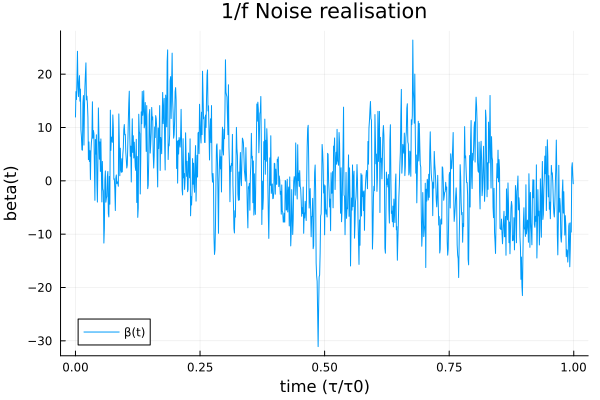

In [55]:
params = get_preset_params("1/f")
S_func = ω -> S(ω; :a => 0, :b => 1, :α => 1.0, :c => 0.0, :ω_c => Inf)
T= 1.0
dt = 1e-3
target_std = 1e-2
t_list, beta_t = generate_beta(S_func, T; dt = dt, target_std = target_std)
plot(t_list, beta_t, label="β(t)", xlabel="time (τ/τ0)", ylabel="beta(t)", title="1/f Noise realisation")


In [56]:
savefig("1_over_f_noise_realisation.png")

"c:\\Users\\vikra\\OneDrive\\Desktop\\project\\notebooks\\1_over_f_noise_realisation.png"

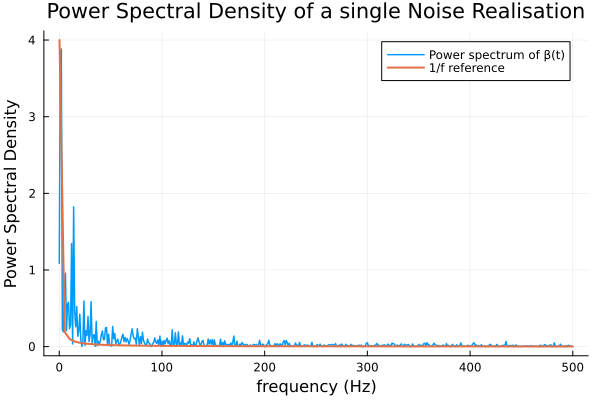

In [58]:
std(beta_t)
plt = plot_spectrum(beta_t, dt; log= false, label="Power spectrum of β(t)")
f=range(1/4,500, 100)
g(x)=1/x
plot!(plt, f, g.(f); label="1/f reference", xlabel="frequency (Hz)", ylabel="Power Spectral Density", lw=2, title="Power Spectral Density of a single Noise Realisation")
savefig("single_realisation_power_spectrum.png")
display(plt)

In [72]:
n_realizations = 1000
t_vec, β_tmp   = generate_beta(S_func, T; dt=dt, target_std=target_std)
N              = length(β_tmp)
fft_len        = div(N,2) + 1          # length of rfft output
psd_sum        = zeros(Float64, fft_len)  # accumulate power spectra

function one_sided_psd(β::Vector{Float64}, dt::Float64)
    N  = length(β)
    βf = rfft(β)                       # real FFT (length N/2+1)
    psd = abs2.(βf) .* (2*dt/N^2)      # scale so ∫PSD dω ≈ var
    psd[1] /= 2                        # DC component not doubled
    if iseven(N)
        psd[end] /= 2                  # Nyquist term (even-length correction)
    end
    return psd
end

for _ in 1:n_realizations
    _, β = generate_beta(S_func, T; dt=dt, target_std=target_std)
    psd_sum .+= one_sided_psd(β, dt)
end

psd_avg = psd_sum ./ n_realizations
freqs   = (0:fft_len-1) .* (1/(N*dt))     # frequency grid (Hz)

# --- reference 1/f line (scaled for eye-guidance) ---------------------------
ref = 1 ./ (freqs .+ 1e-6)              # avoid divide-by-zero at f=0

# --- plot -------------------------------------------------------------------
plot(freqs, psd_avg;
     xscale=:log10, yscale=:log10,
     xlabel="frequency (Hz)", ylabel="Power Spectral Density",
     label = "Average PSD ($n_realizations realisations)",
     linewidth=2)

plot!(freqs, ref; label="1/f reference", linewidth=2, color=:orange)
title!("Average PSD of β(t) — 1/f noise")
xlims!(1e-1, maximum(freqs))
savefig("average_power_spectrum.png")

┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based xscale
└ @ Plots C:\Users\vikra\.julia\packages\Plots\MR7sb\src\utils.jl:106


"c:\\Users\\vikra\\OneDrive\\Desktop\\project\\notebooks\\average_power_spectrum.png"

In [66]:
using LinearAlgebra

In [71]:
scale = sum(psd_avg .* ref) / sum(ref .* ref)
ref_scaled = scale .* ref
mse      = mean((psd_avg .- ref_scaled).^2)
rel_err  = norm(psd_avg .- ref_scaled) / norm(ref_scaled)
log_mse  = mean((log10.(psd_avg) .- log10.(ref_scaled)).^2)

println(mse)
println(rel_err)
println(log_mse)

3.103551616441289e-7
1.0383622408117714
35.26111879881281


In [2]:
sequence = "HAHN"
T = 1.0
n_pulses = 10
pulse_duration = 1e-3

pulses = get_shaped_pulses(sequence, T, n_pulses; pulse_duration=pulse_duration, axis=:x)
plot_pulse_schedule(pulses,T; sequence="Hahn Echo")
savefig("Hahn_echo_pulse_schedule.png")

"c:\\Users\\vikra\\OneDrive\\Desktop\\project\\notebooks\\Hahn_echo_pulse_schedule.png"

In [3]:
sequence = "CPMG"
T = 1.0
n_pulse_list = [1, 2, 4, 8, 16, 32, 64]
pulse_duration = 1e-3
for n_pulses in n_pulse_list
    pulses = get_shaped_pulses(sequence, T, n_pulses; pulse_duration=pulse_duration, axis=:x)
    plot_pulse_schedule(pulses, T; sequence="CPMG with $n_pulses pulses")
    savefig("CPMG_pulse_schedule_$(n_pulses).png")
end



In [4]:
sequence = "CDD"
T = 1.0
level_list = [1,2,3,4,5,6]
pulse_duration = 1e-3
for level in level_list
    pulses = get_shaped_pulses(sequence, T, level; pulse_duration=pulse_duration, axis=:x)
    plot_pulse_schedule(pulses, T; sequence="CDD with level $level")
    savefig("CDD_pulse_schedule_level_$(level).png")
end

In [5]:
sequence = "UDD"
T = 1.0
n_pulse_list = [1, 2, 4, 8, 16, 32, 64]
pulse_duration = 1e-3

for n_pulses in n_pulse_list
    pulses = get_shaped_pulses(sequence, T, n_pulses; pulse_duration=pulse_duration, axis=:x)
    plot_pulse_schedule(pulses, T; sequence="UDD with $n_pulses pulses")
    savefig("UDD_pulse_schedule_$(n_pulses).png")
end

In [6]:
sequence = "PDD"
T = 1.0
n_pulse_list = [1, 2, 4, 8, 16, 32, 64]
pulse_duration = 1e-3
for n_pulses in n_pulse_list
    pulses = get_shaped_pulses(sequence, T, n_pulses; pulse_duration=pulse_duration, axis=:x)
    plot_pulse_schedule(pulses, T; sequence="PDD with $n_pulses pulses")
    savefig("PDD_pulse_schedule_$(n_pulses).png")
end


In [ ]:
sequence = "HAHN"
T        = 1.0
pulse_duration = 1e-3
pulses = get_shaped_pulses(sequence, T, 1; pulse_duration=pulse_duration, axis=:x)
pulse_times = [p.start + pulse_duration/2 for p in pulses]
sequence = "Hahn Echo"
plot_modulation(pulse_times, T; color=:red,
                    sequence="$sequence")
savefig("Hahn_echo_modulation.png")

"c:\\Users\\vikra\\OneDrive\\Desktop\\project\\notebooks\\Hahn_echo_modulation.png"

In [5]:
sequence = "CPMG"
T        = 1.0
pulse_duration = 1e-3
n_pulse_list   = [1, 2, 4, 8, 16, 32, 64]

for N in n_pulse_list
    pulses = get_shaped_pulses(sequence, T, N; pulse_duration=pulse_duration, axis=:x)
    # Use pulse centres for flips:
    pulse_times = [p.start + pulse_duration/2 for p in pulses]

    plot_modulation(pulse_times, T; color=:red,
                    sequence="$sequence with $N pulses")
    savefig("CPMG_modulation_$(N).png")
end


In [6]:
sequence = "UDD"
T        = 1.0
pulse_duration = 1e-3
n_pulse_list   = [1, 2, 4, 8, 16, 32, 64]

for N in n_pulse_list
    pulses = get_shaped_pulses(sequence, T, N; pulse_duration=pulse_duration, axis=:x)
    # Use pulse centres for flips:
    pulse_times = [p.start + pulse_duration/2 for p in pulses]

    plot_modulation(pulse_times, T; color=:red,
                    sequence="$sequence with $N pulses")
    savefig("UDD_modulation_$(N).png")
end


In [7]:
sequence = "PDD"
T        = 1.0
pulse_duration = 1e-3
n_pulse_list   = [1, 2, 4, 8, 16, 32, 64]

for N in n_pulse_list
    pulses = get_shaped_pulses(sequence, T, N; pulse_duration=pulse_duration, axis=:x)
    # Use pulse centres for flips:
    pulse_times = [p.start + pulse_duration/2 for p in pulses]

    plot_modulation(pulse_times, T; color=:red,
                    sequence="$sequence with $N pulses")
    savefig("PDD_modulation_$(N).png")
end


In [2]:
sequence = "CDD"
T        = 1.0
pulse_duration = 1e-3
levels_list   = [1, 2, 3, 4, 5, 6]

for level in levels_list
    pulses = get_shaped_pulses(sequence, T, level; pulse_duration=pulse_duration, axis=:x)
    # Use pulse centres for flips:
    pulse_times = [p.start + pulse_duration/2 for p in pulses]

    plot_modulation(pulse_times, T; color=:red,
                    sequence="$sequence with $level pulses")
    savefig("CDD_modulation_level_$(level).png")
end
